<img src="market insights.jpg" alt="market insights" width="600">

*packages*

In [1]:
# packages
import pandas as pd
import numpy as np
import os
np.random.seed(42)

# scikit learn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# bigquery
from google.cloud import bigquery

*set the connection for BigQuery connection*

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = # introduce your key here

*Initiate client interaction and establish the query.*

In [3]:
# Inicializa el cliente de BigQuery
client = bigquery.Client()

# Ejemplo de consulta a BigQuery
query = """
SELECT 
    date, totals.visits,
    geoNetwork.country, -- region/country
    product.v2ProductName as product, v2ProductCategory as category, productBrand as brand, -- product details
    product.productPrice as price, product.productPrice as revenue, productQuantity as qty, -- invoice detail
    hits.eCommerceAction.action_type as action, -- purchase was made
    channelGrouping as channel
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`, 
     UNNEST (hits) AS hits, UNNEST (hits.product) AS product
WHERE 
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170704';
"""

*get the data into a pandas dataframe*

In [4]:
df = client.query(query).to_dataframe()

In [5]:
df.head()

,date,visits,country,product,category,brand,price,revenue,qty,action,channel
0,20170701,1,Netherlands,Google Snapback Hat Black,Home/Apparel/Headgear/,(not set),22990000,22990000,<NA>,1,Direct
1,20170701,1,Netherlands,Google Snapback Hat Black,Home/Apparel/Headgear/,(not set),22990000,22990000,<NA>,2,Direct
2,20170701,1,Timor-Leste,YouTube Custom Decals,Home/Shop by Brand/YouTube/,(not set),1990000,1990000,<NA>,0,Organic Search
3,20170701,1,Timor-Leste,YouTube Leatherette Notebook Combo,Home/Shop by Brand/YouTube/,(not set),6990000,6990000,<NA>,0,Organic Search
4,20170701,1,Timor-Leste,22 oz YouTube Bottle Infuser,Home/Shop by Brand/YouTube/,(not set),4990000,4990000,<NA>,0,Organic Search


*Validate for the presence of empty data.*

In [6]:
df.isnull().sum()

date             0
visits           0
country          0
product          0
category         0
brand            0
price            0
revenue          0
qty         123124
action           0
channel          0
dtype: int64

*define the date*

In [7]:
df['year'] = df['date'].apply(lambda x: x[:4])
df['month'] = df['date'].apply(lambda x: x[4:6])
df['day'] = df['date'].apply(lambda x: x[6:])
df['date'] = df['year'].astype('str') + '-' + df['month'].astype('str') + '-' + df['day'].astype('str')
df['date'] = df['date'].astype('datetime64')

*get the day of the week* 

In [8]:
df['week day'] = df['date'].dt.dayofweek

*if friday or saturday then is weekend*

In [9]:
df['weekend day'] = np.where(df['week day'].isin([4, 5, 6]), 1, 0)

In [10]:
df.head(3)

,date,visits,country,product,category,brand,price,revenue,qty,action,channel,year,month,day,week day,weekend day
0,2017-07-01,1,Netherlands,Google Snapback Hat Black,Home/Apparel/Headgear/,(not set),22990000,22990000,<NA>,1,Direct,2017,07,01,5,1
1,2017-07-01,1,Netherlands,Google Snapback Hat Black,Home/Apparel/Headgear/,(not set),22990000,22990000,<NA>,2,Direct,2017,07,01,5,1
2,2017-07-01,1,Timor-Leste,YouTube Custom Decals,Home/Shop by Brand/YouTube/,(not set),1990000,1990000,<NA>,0,Organic Search,2017,07,01,5,1


*retrieve the countries with the highest visitation rates.*

In [11]:
df[['country', 'visits']].\
groupby(by = ['country']).\
agg('sum').\
sort_values(by = 'visits', ascending = False).\
head(5)

,visits
country,
United States,55876
India,7074
United Kingdom,6134
Canada,4339
Japan,3232


*pre processing the data*

In [12]:
columns = ['product', 'category', 'price', 'action', 'channel', 'week day', 'weekend day']
num_columns = ['price', 'action', 'week day', 'weekend day']
cat_columns = ['product', 'category', 'action', 'channel']

X = df[df['country'] == 'United States'][columns]
X['price'] = X['price']/1e6

In [13]:
X.head(1)

,product,category,price,action,channel,week day,weekend day
39,Google G Noise-reducing Bluetooth Headphones,(not set),0.0,0,Social,5,1


*given that the majority of features are categorical, encoding the data is imperative for seamless processing.*

In [14]:
ordinal_encoder = OrdinalEncoder()
X[cat_columns] = ordinal_encoder.fit_transform(X[cat_columns])

In [15]:
X.head()

,product,category,price,action,channel,week day,weekend day
39,92.0,2.0,0.0,0.0,6.0,5,1
40,180.0,2.0,0.0,0.0,6.0,5,1
41,253.0,0.0,2.99,3.0,6.0,5,1
104,270.0,54.0,1.99,0.0,3.0,5,1
105,272.0,54.0,6.99,0.0,3.0,5,1


In the subsequent phase, our focus shifts towards meticulously selecting the optimal cluster. This pivotal step involves leveraging inertia as a determining factor to identify clusters with the minimal inertia.

In [16]:
clusters = [5, 10, 15, 20, 25]
kmeans_per_k = [KMeans(n_clusters = k, init = 'k-means++', n_init = 'auto', random_state = 42).fit(X)
                for k in clusters]
inertias = [model.inertia_ for model in kmeans_per_k]

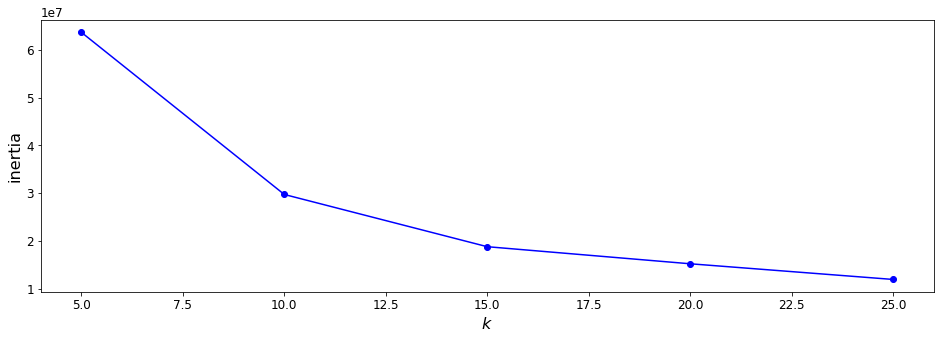

In [17]:
plt.figure(figsize = (16,5))
plt.plot(clusters, inertias, "bo-")
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("inertia", fontsize = 16)
plt.show()

Prior to determining the number of clusters based on **inertia**, our initial step involves delving into the silhouette score. This exploration aids us in assessing the degree of separation among the clusters.

In [18]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k]

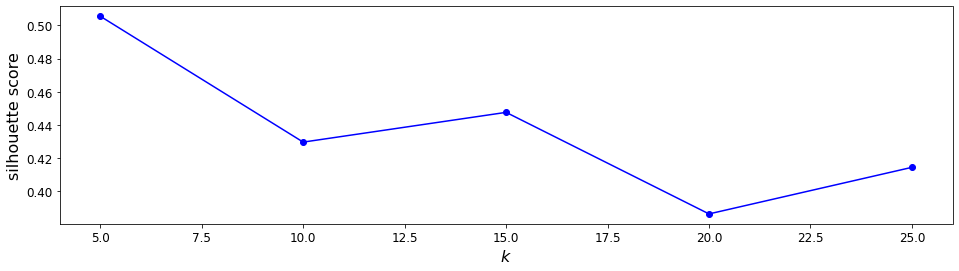

In [19]:
plt.figure(figsize = (16,4))
plt.plot(clusters, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("silhouette score", fontsize = 16)
plt.show()

Upon thorough review, it becomes evident that the optimal **silhouette** score is achieved when utilizing **5** clusters. Therefore, for this particular scenario, we determine that the ideal number of clusters is **5**.

In [21]:
k = 5
kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 'auto', random_state = 42)
y_pred = kmeans.fit_predict(X)

In [22]:
kmeans.inertia_

63680110.34232402

Ultimately, by employing 5 clusters, we attain a **silhouette** score of 0.5, which, while not optimal, remains promising.

In [23]:
silhouette_score(X, kmeans.labels_)

0.5055776618783082

In [24]:
X['cluster'] = kmeans.labels_

Following the clustering of all instances, we can extract valuable insights that pave the way for establishing overarching strategies.

As evident from the chart below, a particular cluster exhibits pronounced interactions on Mondays and Sundays, with a varied proportion of engagements observed on the remaining days.

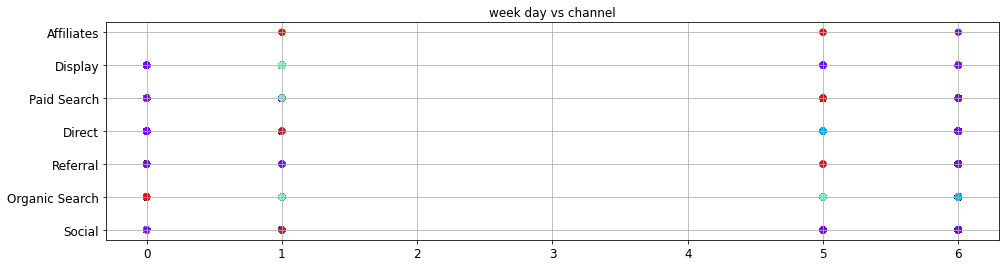

In [25]:
plt.figure(figsize = (16,4))
plt.scatter(X["week day"], 
            df[df['country'] == 'United States']['channel'], 
            c=kmeans.labels_, 
            cmap="rainbow")
plt.title('week day vs channel')
plt.grid(True)
plt.show()

In the examination of the **price** versus weekdays, it is apparent that Mondays and Sundays stand out with **elevated prices**, particularly favored by the purple cluster. Conversely, Saturdays see a prevalence of lower-priced items being purchased.

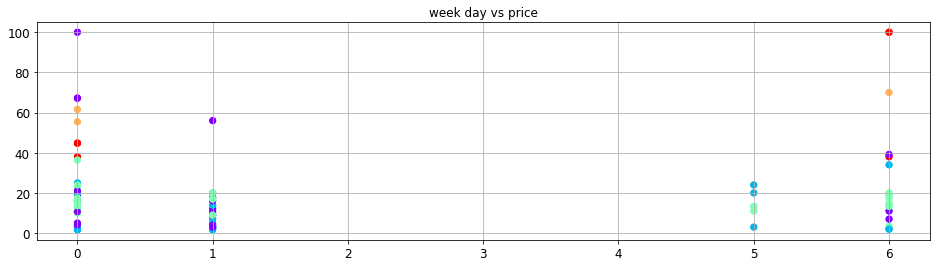

In [27]:
plt.figure(figsize = (16,4))
plt.scatter(X[X['action'] == 6]['week day'], 
            X[X['action'] == 6]['price'], 
            c=X[X['action'] == 6]['cluster'], 
            cmap="rainbow")
plt.title('week day vs price')
plt.grid(True)
plt.show()

In [28]:
condition = df['country'] == 'United States'
df_product = X
df_product = df_product[['cluster', 'product', 'action']]
df_product = df_product[df_product['action'] == 6].drop(columns = ['action'])

In [29]:
products = df_product.\
            groupby(by = ['product'], as_index = False).agg('count').\
            sort_values(by = 'cluster', ascending = False).\
            head(5)['product']

# =========================================================================
# get the product list
products = [p for p in products]

# =========================================================================
# get the name of the items
df_catalog = df[df['country'] == 'United States'][['category', 'product']].\
                rename(columns = {'category' : 'category name', 'product' : 'product name'})

# =========================================================================
# concat catalog and the df 
df_product = pd.concat([X, df_catalog], axis = 1)
df_product = df_product[df_product['product'].isin(products)]

Our current focus shifts towards comprehending the intricate relationship between items and pricing. Notably, interactions involving higher prices are predominantly concentrated within the red, orange, and to some extent, the purple clusters. Conversely, the blue and green clusters exhibit a noticeable trend towards products with lower price points.

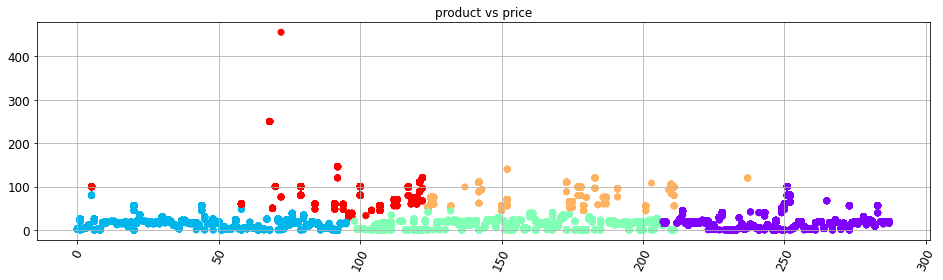

In [30]:
plt.figure(figsize = (16,4))
plt.scatter(X['product'], 
            X['price'], 
            c=X['cluster'], 
            cmap="rainbow")
plt.title('product vs price')
plt.grid(True)
plt.xticks(rotation = 65)
plt.show()

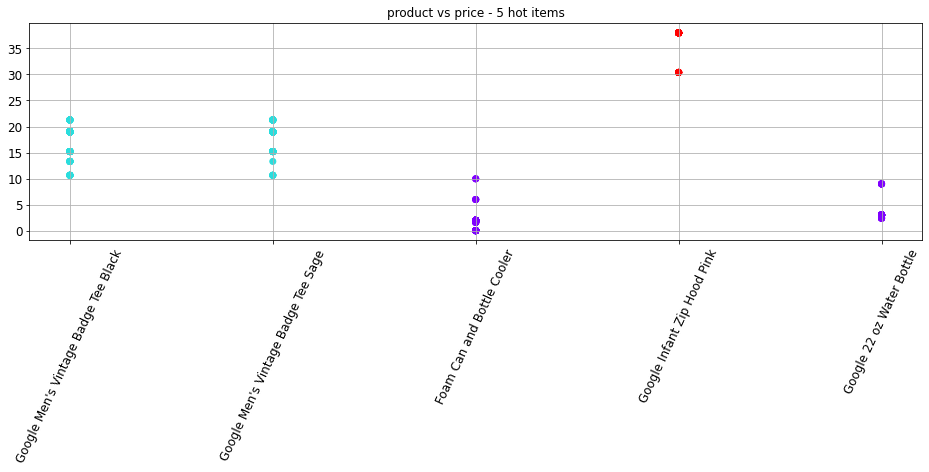

In [31]:
plt.figure(figsize = (16,4))
plt.scatter(df_product['product name'], 
            df_product['price'], 
            c=df_product['cluster'], 
            cmap="rainbow")
plt.title('product vs price - 5 hot items')
plt.grid(True)
plt.xticks(rotation = 65)
plt.show()

Clusters red and orange exhibit a propensity for engaging with a comparatively smaller range of items, particularly in contrast to the other clusters. Notably, the blue cluster displays a robust inclination towards interacting with a diverse array of items spanning multiple categories.

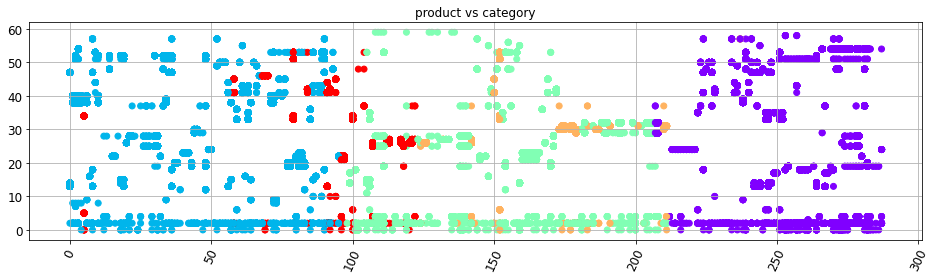

In [32]:
plt.figure(figsize = (16,4))
plt.scatter(X['product'], 
            X['category'], 
            c=X['cluster'], 
            cmap="rainbow")
plt.title('product vs category')
plt.grid(True)
plt.xticks(rotation = 65)
plt.show()

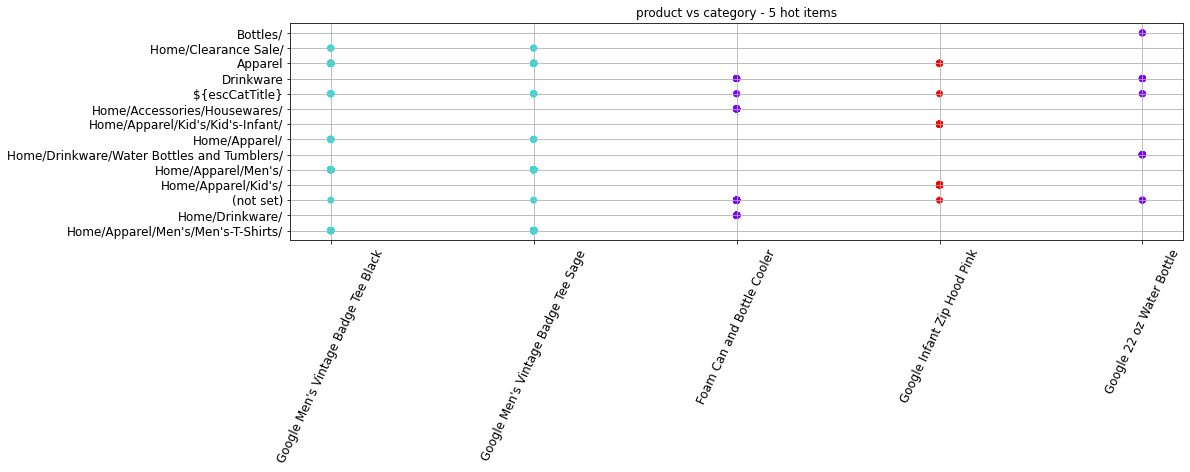

In [33]:
plt.figure(figsize = (16,4))
plt.scatter(df_product['product name'], 
            df_product['category name'], 
            c=df_product['cluster'], 
            cmap="rainbow")
plt.title('product vs category - 5 hot items')
plt.grid(True)
plt.xticks(rotation = 65)
plt.show()

The social, direct, and paid search channels prominently exhibit interactions with items of higher value, notably accentuated by the red cluster. This observation aligns with our prior findings, where the purple cluster consistently engages with lower-priced items.

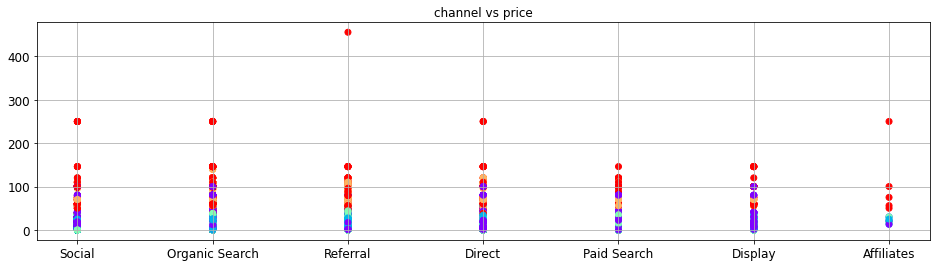

In [34]:
plt.figure(figsize = (16,4))
plt.scatter(df[df['country'] == 'United States']['channel'], 
            X["price"], 
            c=kmeans.labels_, 
            cmap="rainbow")
plt.title('channel vs price')
plt.grid(True)
plt.show()

In conclusion, clusters red and orange demonstrate a proclivity for interactions involving higher prices, while the remaining clusters tend to engage with lower-priced items.

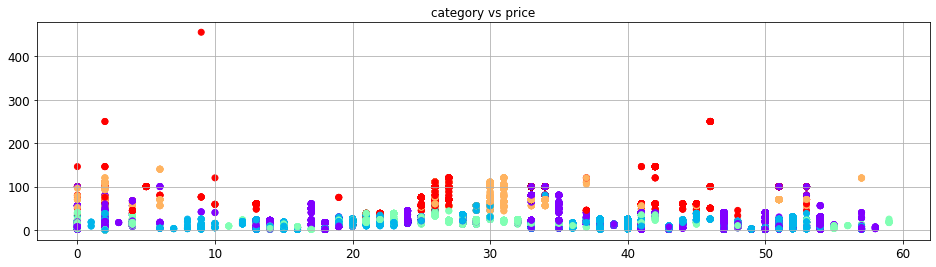

In [35]:
plt.figure(figsize = (16,4))
plt.scatter(X["category"], 
            X['price'], 
            c=kmeans.labels_, 
            cmap="rainbow")
plt.title('category vs price')
plt.grid(True)
plt.show()

***conclusions***<br>

In summation, it is evident that certain clusters predominantly engage with **lower-priced items**, while two clusters exhibit interactions with **higher-priced** products. This phenomenon could likely stem from the nature of the products themselves; some clusters appear to be centered around home-related items, while others revolve around clothing. Consequently, delving further into the interplay between product interactions, prices, and categories could yield valuable insights.

Drawing from the preceding insights into cluster-product-price **interactions**, we can formulate a strategic packaging approach. This entails crafting distinct package tiers such as basic, best value, and premium, all with the overarching goal of bolstering our market share.

It's crucial to emphasize that the foundational strategy outlined here is a hypothesis. To refine it further, a deeper exploration of price behavior is imperative to ascertain the market's elasticity accurately.

<img src="package.png" alt="package" width="600">